# Imports

In [ ]:
!pip install optuna xgboost
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import optuna
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import resample

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 4.8 MB/s eta 0:00:00


# Data Extraction


In [ ]:
# Loading the datasets
df_01 = pd.read_csv('/content/drive/MyDrive/Data Literacy Project/movies_with_release_type.csv')
df_02 = pd.read_csv('/content/drive/MyDrive/Data Literacy Project/df_full_unfiltered.csv')

In [ ]:
# 1. Defining the columns to bring over from df_02
# We must include 'imdb_id' here so we have the key to match on
cols_to_add = [
    'imdb_id',
    'director_name',
    'director_popularity',
    'lead_actor_name',
    'lead_actor_popularity',
    'avg_top5_cast_popularity',
    'imdb_title',
    'imdb_rating',
    'imdb_votes'
]

# 2. Creating a subset of df_02 with only the relevant columns
# We also drop duplicates on 'imdb_id' to prevent accidental row multiplication
# (just in case df_02 has multiple rows for the same movie)
df_02_subset = df_02[cols_to_add].drop_duplicates(subset=['imdb_id'])

# 3. Merging df_01 with the subset
df_merged = pd.merge(df_01, df_02_subset, on='imdb_id', how='left')

# 4. Verifying the results
print(f"Original df_01 rows: {len(df_01)}")
print(f"Merged df rows:      {len(df_merged)}")

# Setting the option to show all columns (otherwise we cannot observe each column)
pd.set_option('display.max_columns', None)

# Checking the first few rows to see the new columns
print(df_merged.head())

df_merged.to_csv("/content/drive/MyDrive/Data Literacy Project/raw_dataset_arda.csv", index=False)

Original df_01 rows: 23998
Merged df rows:      23998
   adult                     backdrop_path  \
0  False  /iMYoly1SBrvnuWdDnfW3Szglz1d.jpg   
1  False  /a4r8xcRwTgKIUKdWtxFXyxTZLeN.jpg   
2  False  /eAIHqfS3kXm7kZl4j7ZBfdegyEz.jpg   
3  False  /3RWsSQlqzRjsuqSRmoyggy74UA7.jpg   
4  False  /auT0H5fFUnPKjHNj0OkQMkxdbl2.jpg   

                               belongs_to_collection     budget  \
0                                                NaN   28000000   
1  {'id': 14563, 'name': 'The Ring Collection', '...   25000000   
2  {'id': 14890, 'name': 'Bad Boys Collection', '...   90000000   
3                                                NaN  144000000   
4  {'id': 304378, 'name': 'Independence Day Colle...  165000000   

                                              genres  \
0  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
1                     [{'id': 27, 'name': 'Horror'}]   
2  [{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...   
3  [{'id': 28, 'name': 'Action'}, {'id': 1

In [ ]:
print(f"Number of rows: {len(df_merged)}")
for col in df_merged.columns:
    print(col)

Number of rows: 23998
adult
backdrop_path
belongs_to_collection
budget
genres
homepage
id
imdb_id
origin_country
original_language
original_title
overview
popularity
poster_path
production_companies
production_countries
release_date
revenue
runtime
spoken_languages
status
tagline
title
video
vote_average
vote_count
credits
keywords
release_strategy
is_streaming_verified
director_name
director_popularity
lead_actor_name
lead_actor_popularity
avg_top5_cast_popularity
imdb_title
imdb_rating
imdb_votes


In [ ]:
# For observing the dataset
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23998 entries, 0 to 23997
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   adult                     23998 non-null  bool   
 1   backdrop_path             11768 non-null  object 
 2   belongs_to_collection     2160 non-null   object 
 3   budget                    23998 non-null  int64  
 4   genres                    23998 non-null  object 
 5   homepage                  6386 non-null   object 
 6   id                        23998 non-null  int64  
 7   imdb_id                   14311 non-null  object 
 8   origin_country            23998 non-null  object 
 9   original_language         23998 non-null  object 
 10  original_title            23998 non-null  object 
 11  overview                  22920 non-null  object 
 12  popularity                23998 non-null  float64
 13  poster_path               21837 non-null  object 
 14  produc

# Data Work

In [ ]:
print(df_merged['release_strategy'].value_counts(dropna=False))

release_strategy
theatrical    9208
unknown       9064
streaming     5726
Name: count, dtype: int64


In [ ]:
# Ensuring release_date is in datetime format
# errors='coerce' turns unparseable dates into NaT (Not a Time) so they don't break the code
df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], format='mixed', errors='coerce')

# Creating the 'period' column for the model target class
conditions = [
    df_merged['release_date'] <= '2020-03-10',
    (df_merged['release_date'] >= '2020-03-11') & (df_merged['release_date'] <= '2021-12-31'),
    df_merged['release_date'] >= '2022-01-01'
]

choices = ['Before COVID', 'During COVID', 'After COVID']

df_merged['period'] = np.select(conditions, choices, default='Unknown')

In [ ]:
# Creating the 'roi' column for further analysis of economic data
# ROI (Return on Investment) = (Revenue - Budget) / Budget
df_merged['roi'] = (df_merged['revenue'] - df_merged['budget']) / df_merged['budget']

In [ ]:
# Creating the 'collection_flag' column to observe the effects of being a part of a franchise
df_merged['collection_flag'] = df_merged['belongs_to_collection'].notna().astype(int)

# Checking the result
#print(df_merged[['belongs_to_collection', 'collection_flag']].head())

In [ ]:
'''
# Filtering the movies
# We create a new DataFrame with only the rows that meet all three conditions
df_filtered = df_merged[
    (df_merged['budget'] > 1000) &
    (df_merged['revenue'] > 1000) &
    (df_merged['runtime'] > 40)
].copy() # .copy() is good practice to avoid SettingWithCopy warnings later

# Checking the results
print(df_filtered[['title', 'period', 'roi', 'budget', 'revenue']].head())
print(f"Rows before filter: {len(df_merged)}")
print(f"Rows after filter:  {len(df_filtered)}")
'''

'\n# --- 4. Filter the movies ---\n# We create a new DataFrame with only the rows that meet all three conditions\ndf_filtered = df_merged[\n    (df_merged[\'budget\'] > 1000) &\n    (df_merged[\'revenue\'] > 1000) &\n    (df_merged[\'runtime\'] > 40)\n].copy() # .copy() is good practice to avoid SettingWithCopy warnings later\n\n# Check the results\nprint(df_filtered[[\'title\', \'period\', \'roi\', \'budget\', \'revenue\']].head())\nprint(f"Rows before filter: {len(df_merged)}")\nprint(f"Rows after filter:  {len(df_filtered)}")\n'

In [ ]:
# 1. Defining a helper function to extract data
def extract_list_values(x, key=None):
    """
    Parses a stringified list of dicts and extracts values for a specific key.
    If no key is provided, it just ensures the data is a list (for origin_country).
    """
    if pd.isna(x):
        return []  # Returning empty list if the cell is empty

    # If the data is a string (e.g. "[{'id': 1}, {'id': 2}]"), we convert it to a python list
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return [] # Return empty if parsing fails

    # If we just need the list as-is (for example we need in the case of origin country from the tmdb data)
    if key is None:
        return x

    # Otherwise, extracting the specific value (e.g., 'name') from each item in the list
    return [i[key] for i in x if isinstance(i, dict) and key in i]

# 2. Applying the function to columns (by overwriting)

# Case 1: genres -> Need 'name'
df_merged['genres'] = df_merged['genres'].apply(lambda x: extract_list_values(x, key='name'))

# Case 2: production_companies -> Need 'name'
df_merged['production_companies'] = df_merged['production_companies'].apply(lambda x: extract_list_values(x, key='name'))

# Case 3: origin_country -> Need it as-is (but we again ensure it's a real list, not a string)
df_merged['origin_country'] = df_merged['origin_country'].apply(lambda x: extract_list_values(x, key=None))

# Case 4: production_countries -> Need 'name'
df_merged['production_countries'] = df_merged['production_countries'].apply(lambda x: extract_list_values(x, key='name'))

# Case 5: spoken_languages -> Need 'english_name'
df_merged['spoken_languages'] = df_merged['spoken_languages'].apply(lambda x: extract_list_values(x, key='english_name'))

# 3. Verifying the results
# The columns of our dataset now contain clean Python lists of strings, e.g., ['Action', 'Thriller'].
print(df_merged[['genres', 'production_companies', 'origin_country', 'production_countries','spoken_languages']].head())

                                 genres  \
0                       [Comedy, Drama]   
1                              [Horror]   
2             [Thriller, Action, Crime]   
3             [Action, Fantasy, Comedy]   
4  [Action, Adventure, Science Fiction]   

                                production_companies origin_country  \
0                 [Participant, Smokehouse Pictures]           [US]   
1  [Paramount Pictures, Macari/Edelstein, Parkes+...           [US]   
2  [Columbia Pictures, 2.0 Entertainment, Don Sim...           [US]   
3  [Ghost Corps, Columbia Pictures, Village Roads...           [US]   
4  [20th Century Fox, TSG Entertainment, Centropo...           [US]   

         production_countries    spoken_languages  
0  [United States of America]           [English]  
1  [United States of America]           [English]  
2  [United States of America]  [English, Spanish]  
3  [United States of America]           [English]  
4  [United States of America]           [English]  


In [ ]:
# List of columns to create flags for
cols_to_check = [
    'production_companies',
    'origin_country',
    'production_countries',
    'spoken_languages'
]

for col in cols_to_check:
    # We'll name the new column with a suffix like '_complexity' or '_count_cat'
    new_col_name = f"{col}_count_cat"

    # Apply the 0, 1, 2 logic
    df_merged[new_col_name] = df_merged[col].apply(
        lambda x: 0 if len(x) == 0 else (1 if len(x) == 1 else 2)
    )

# Checking the results
cols_to_show = ['production_companies', 'production_companies_count_cat',
                'origin_country', 'origin_country_count_cat']

print(df_merged[cols_to_show].head(10))

# Checking step for our code. Can't be too cautious :)
print("\nDistribution for production_companies:")
print(df_merged['production_companies_count_cat'].value_counts().sort_index())

                                production_companies  \
0                 [Participant, Smokehouse Pictures]   
1  [Paramount Pictures, Macari/Edelstein, Parkes+...   
2  [Columbia Pictures, 2.0 Entertainment, Don Sim...   
3  [Ghost Corps, Columbia Pictures, Village Roads...   
4  [20th Century Fox, TSG Entertainment, Centropo...   
5  [Rox Productions, Revolution Studios, Maple Ca...   
6  [Broken Lizard Industries, Cataland Films, Nee...   
7                  [Scoundrel Media, Infinity Films]   
8  [Insurge Pictures, Blumhouse Productions, Aram...   
9  [Handsomecharlie Films, Cross Creek Pictures, ...   

   production_companies_count_cat origin_country  origin_country_count_cat  
0                               2           [US]                         1  
1                               2           [US]                         1  
2                               2           [US]                         1  
3                               2           [US]                         1 

In [ ]:
# List of columns to drop (I have removed 'id' from this list)
cols_to_drop = [
    'belongs_to_collection',
    'backdrop_path',
    'homepage',
    'imdb_id',
    'original_title',
    'overview',
    'poster_path',
    'release_date',
    'status',
    'tagline',
    'title',
    'video',
    'credits',
    'keywords',
    'is_streaming_verified'
]

# Dropping the columns from the filtered dataset
df_final = df_merged.drop(columns=cols_to_drop, errors='ignore')

# Setting 'id' as the index. We need to do this since we have to have a unique id that we can use to choose elements.
df_final.set_index('id', inplace=True)

# Verifying the result
print(df_final.head())
print(f"Final shape: {df_final.shape}")

       adult     budget                                genres origin_country  \
id                                                                             
10317  False   28000000                       [Comedy, Drama]           [US]   
14564  False   25000000                              [Horror]           [US]   
38700  False   90000000             [Thriller, Action, Crime]           [US]   
43074  False  144000000             [Action, Fantasy, Comedy]           [US]   
47933  False  165000000  [Action, Adventure, Science Fiction]           [US]   

      original_language  popularity  \
id                                    
10317                en      1.0390   
14564                en      2.1118   
38700                en      7.9524   
43074                en      4.8469   
47933                en      9.2105   

                                    production_companies  \
id                                                         
10317                 [Participant, Smokehous

In [ ]:
# 1. Converting Boolean to Int for the 'adult' category.
df_final['adult'] = df_final['adult'].astype(int)

# 2. Dropping columns that are text-heavy or replaced by popularity scores. With the new variables they are no more necessary.
cols_to_drop_pre_split = ['director_name', 'lead_actor_name', 'imdb_title']
df_final = df_final.drop(columns=cols_to_drop_pre_split, errors='ignore')

# 3. Handling Top Languages (Simplifying sparse classes)
# We keep top 10 languages, map others to 'Other'
top_languages = df_final['original_language'].value_counts().nlargest(10).index
df_final['original_language'] = df_final['original_language'].apply(lambda x: x if x in top_languages else 'Other')

# 4. Handling List Columns (Dropping the complex ones we already counted)
# We keep 'genres' because we will encode it later.
# We drop companies/countries because we created the _count_cat columns for them.
list_cols_to_drop = ['production_companies', 'production_countries', 'spoken_languages', 'origin_country']
df_final = df_final.drop(columns=list_cols_to_drop, errors='ignore')

# 5. Turning "Infinity" (caused by 0 budget) into NaN so we can fill it later
df_final['roi'] = df_final['roi'].replace([np.inf, -np.inf], np.nan)

# Verifying status before split
print(f"Rows ready for splitting: {len(df_final)}")

df_final.to_csv("/content/drive/MyDrive/Data Literacy Project/train_model_dataset_arda.csv", index=False)

Rows ready for splitting: 23998


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23998 entries, 10317 to 1587733
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   adult                           23998 non-null  int64  
 1   budget                          23998 non-null  int64  
 2   genres                          23998 non-null  object 
 3   original_language               23998 non-null  object 
 4   popularity                      23998 non-null  float64
 5   revenue                         23998 non-null  int64  
 6   runtime                         23998 non-null  int64  
 7   vote_average                    23998 non-null  float64
 8   vote_count                      23998 non-null  int64  
 9   release_strategy                23998 non-null  object 
 10  director_popularity             16193 non-null  float64
 11  lead_actor_popularity           16193 non-null  float64
 12  avg_top5_cast_popularity       

# Data Split

In [ ]:
# 1. Defining Features (X) and Target (y)
# We drop 'period' from X because it is the target we want to predict
y = df_final['period']
X = df_final.drop(columns=['period'])

# 2. First Split: Separating out the TEST set (e.g., 15% of total data)
# stratify=y ensures the class distribution (Before/During/After) is identical to the original
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

# 3. Second Split: Separating TRAIN and VALIDATION sets
# We split the remaining 85% (X_temp).
# To get roughly 15% of the TOTAL original data for validation, we split X_temp by ~17.6%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
)

# 4. Verification
print(f"Train shape: {X_train.shape} ({len(X_train)/len(X):.1%})")
print(f"Val shape:   {X_val.shape}   ({len(X_val)/len(X):.1%})")
print(f"Test shape:  {X_test.shape}  ({len(X_test)/len(X):.1%})")

# Checking stratification (distributions should be nearly identical)
print("\nTarget Distribution (Train):\n", y_train.value_counts(normalize=True))
print("\nTarget Distribution (Test):\n", y_test.value_counts(normalize=True))

Train shape: (16807, 21) (70.0%)
Val shape:   (3591, 21)   (15.0%)
Test shape:  (3600, 21)  (15.0%)

Target Distribution (Train):
 period
Before COVID    0.617005
After COVID     0.207830
During COVID    0.175165
Name: proportion, dtype: float64

Target Distribution (Test):
 period
Before COVID    0.616944
After COVID     0.207778
During COVID    0.175278
Name: proportion, dtype: float64


# Data Imputation & Encoding

In [ ]:
# 1. Imputing Missing Values (Popularity/Votes)
# We fill with 0 based on our previous strategy
cols_to_fill_0 = ['director_popularity', 'lead_actor_popularity', 'avg_top5_cast_popularity',
                  'imdb_rating', 'imdb_votes', 'vote_average', 'vote_count']

for df in [X_train, X_val, X_test]:
    df[cols_to_fill_0] = df[cols_to_fill_0].fillna(0)

# Imputing ROI
# We calculate the median ONLY on the Training set to avoid "peeking" at the test data. This means no data leakage
roi_median = X_train['roi'].median()

# Adding a flag column so the model knows we faked this data
for df in [X_train, X_val, X_test]:
    df['roi_is_missing'] = df['roi'].isna().astype(int)
    df['roi'] = df['roi'].fillna(roi_median)

print(f"Missing ROI filled with median value: {roi_median:.2f}")

# 2. Encoding GENRES (MultiLabelBinarizer)
mlb = MultiLabelBinarizer()
mlb.fit(X_train['genres']) # Learn genres from TRAIN only

known_genres = set(mlb.classes_)
def filter_genres(genre_list):
    return [g for g in genre_list if g in known_genres]

# Transforming all sets
X_train_genres = mlb.transform(X_train['genres'])
X_val_genres   = mlb.transform(X_val['genres'].apply(filter_genres))
X_test_genres  = mlb.transform(X_test['genres'].apply(filter_genres))

# Creating DataFrames for genres
genre_cols = [f"genre_{c}" for c in mlb.classes_]
X_train_genres_df = pd.DataFrame(X_train_genres, columns=genre_cols, index=X_train.index)
X_val_genres_df   = pd.DataFrame(X_val_genres,   columns=genre_cols, index=X_val.index)
X_test_genres_df  = pd.DataFrame(X_test_genres,  columns=genre_cols, index=X_test.index)

# 3. Encoding CATEGORICALS (OneHotEncoder)
# 'release_strategy' and 'original_language' are the remaining categoricals
ohe_cols = ['release_strategy', 'original_language']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=int)
X_train_ohe = ohe.fit_transform(X_train[ohe_cols])
X_val_ohe   = ohe.transform(X_val[ohe_cols])
X_test_ohe  = ohe.transform(X_test[ohe_cols])

# Creating DataFrames for OHE
ohe_names = ohe.get_feature_names_out(ohe_cols)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_names, index=X_train.index)
X_val_ohe_df   = pd.DataFrame(X_val_ohe,   columns=ohe_names, index=X_val.index)
X_test_ohe_df  = pd.DataFrame(X_test_ohe,  columns=ohe_names, index=X_test.index)

# 4. Final Step
cols_to_drop_encoding = ['genres'] + ohe_cols

def stitch_dataframe(original, genres, ohe):
    clean = original.drop(columns=cols_to_drop_encoding)
    return pd.concat([clean, genres, ohe], axis=1)

X_train_final = stitch_dataframe(X_train, X_train_genres_df, X_train_ohe_df)
X_val_final   = stitch_dataframe(X_val,   X_val_genres_df,   X_val_ohe_df)
X_test_final  = stitch_dataframe(X_test,  X_test_genres_df,  X_test_ohe_df)

print("Processing complete.")
print(f"Final Train Columns: {X_train_final.shape[1]}")

Missing ROI filled with median value: -0.07
Processing complete.
Final Train Columns: 52


# Label Encoding

In [ ]:
# Initializing the encoder
le = LabelEncoder()

# Fitting on Train, transforming all
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Checkking the mapping (e.g., 0='After COVID', 1='Before COVID'...)
print("Label Mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

Label Mapping: {'After COVID': 0, 'Before COVID': 1, 'During COVID': 2}


# Linear Regression

In [ ]:

def objective_lr(trial):
    # 1. Defining the Search Space
    param = {
        'C': trial.suggest_float('C', 1e-4, 10.0, log=True), # Search from 0.0001 to 10
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'max_iter': 3000  # Ensure it has enough time to converge
    }

    # 2. Initializing and Training
    model = LogisticRegression(**param, random_state=42)
    model.fit(X_train_final, y_train_enc)

    # 3. Predicting and Evaluating on VALIDATION Set
    preds = model.predict(X_val_final)
    accuracy = accuracy_score(y_val_enc, preds)

    return accuracy

# Creating the study
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=20) # 20 trials is usually enough for Logistic Regression

print("Best LR Params:", study_lr.best_params)
print("Best LR Accuracy:", study_lr.best_value)


[I 2026-01-20 22:28:41,460] A new study created in memory with name: no-name-d421597f-2c74-4ab9-aed6-01bb00a2844d
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2026-01-20 22:29:58,250] Trial 0 finished with value: 0.621832358674464 and parameters: {'C': 0.006757740539714279, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.621832358674464.
[I 2026-01-20 22:29:58,582] Trial 1 finished with value: 0.6176552492341966 and parameters: {'C': 0.000374456749835545, 'solver': 'liblinear'}. Best is trial 0 with value: 0.621832358674464

Best LR Params: {'C': 5.356286854107005, 'solver': 'lbfgs'}
Best LR Accuracy: 0.6229462545252019


# XGBoost

In [ ]:
def calculate_multiclass_gini(y_true, y_probs, multi_class='ovr'):
    """
    Calculates Gini = 2 * AUC - 1 for multiclass data.
    """
    # Calculating AUC
    auc = roc_auc_score(y_true, y_probs, multi_class=multi_class, average='weighted')

    # Converting to Gini
    gini = 2 * auc - 1
    return gini

def objective_xgb(trial):
    # 1. Defining the Search Space
    '''
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        #'objective': 'multi:softmax',
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_jobs': -1, # Use all CPU cores
        'random_state': 42
    }

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 700),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        #'objective': 'multi:softmax',
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_jobs': -1, # Use all CPU cores
        'random_state': 42
    }
    '''

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        #'objective': 'multi:softmax',
        'objective': 'multi:softprob',
        'num_class': 3,
        'n_jobs': -1, # Use all CPU cores
        'random_state': 42
    }

    # 2. Initializing and Training
    model = xgb.XGBClassifier(**param)

    # 3. Predicting and Evaluating
    # Fitting the model
    model.fit(X_train_final, y_train_enc, verbose=False)

    # We need to get Probabilities (needed for Gini), not just class predictions
    preds_proba = model.predict_proba(X_val_final)

    # Calculating Gini
    gini_score = calculate_multiclass_gini(y_val_enc, preds_proba)

    return gini_score  # Optuna will now maximize Gini instead of Accuracy

# Running the optimization
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=60)

print(f"Best Gini Score: {study_xgb.best_value:.4f}")

[I 2026-01-20 22:47:43,154] A new study created in memory with name: no-name-9f22fc9f-3c99-48b2-bf02-c1c11a12299e
[I 2026-01-20 22:47:53,546] Trial 0 finished with value: 0.4935775723482032 and parameters: {'n_estimators': 309, 'max_depth': 3, 'learning_rate': 0.1334902638922243, 'subsample': 0.9205557942271678, 'colsample_bytree': 0.9703324492873311}. Best is trial 0 with value: 0.4935775723482032.
[I 2026-01-20 22:48:12,739] Trial 1 finished with value: 0.5084383924073177 and parameters: {'n_estimators': 594, 'max_depth': 8, 'learning_rate': 0.040561847739935, 'subsample': 0.7109305924151583, 'colsample_bytree': 0.731822334874199}. Best is trial 1 with value: 0.5084383924073177.
[I 2026-01-20 22:48:20,053] Trial 2 finished with value: 0.5179737956910146 and parameters: {'n_estimators': 219, 'max_depth': 9, 'learning_rate': 0.034947438115772916, 'subsample': 0.7313258508989866, 'colsample_bytree': 0.859474706778434}. Best is trial 2 with value: 0.5179737956910146.
[I 2026-01-20 22:48:

Best Gini Score: 0.5180


                           Feature  Gini_Importance
51            original_language_zh         0.057418
38      release_strategy_streaming         0.056077
48            original_language_ja         0.029344
7              director_popularity         0.025970
3                          revenue         0.025079
49            original_language_ko         0.024284
6                       vote_count         0.024183
50            original_language_ru         0.023770
44            original_language_es         0.022489
45            original_language_fr         0.022294
11                      imdb_votes         0.022047
37                   genre_Western         0.021704
15        origin_country_count_cat         0.021700
8            lead_actor_popularity         0.021556
18                  roi_is_missing         0.020979
46            original_language_hi         0.020499
43            original_language_en         0.020307
9         avg_top5_cast_popularity         0.019857
29          

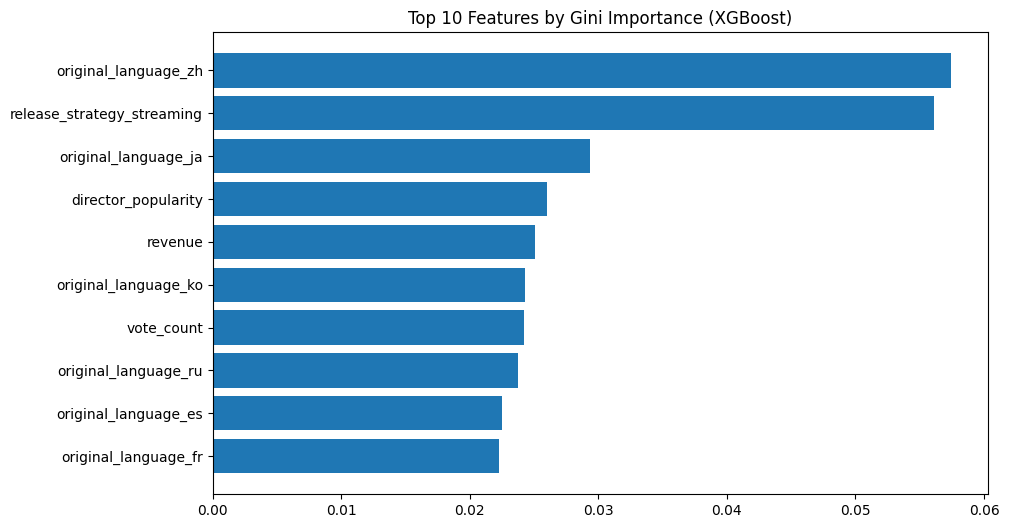

In [ ]:
# 1. Retraining best model
best_xgb = xgb.XGBClassifier(**study_xgb.best_params)
best_xgb.fit(X_train_final, y_train_enc)

# 2. Extracting Feature Importances (Gini Impurity Reduction)
importances = best_xgb.feature_importances_
feature_names = X_train_final.columns

# 3. Creating a DataFrame for easy viewing
feature_gini_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini_Importance': importances
}).sort_values(by='Gini_Importance', ascending=False)

# 4. Displaying Top 10 Features
#print(feature_gini_df.head(10))
print(feature_gini_df)

# 5. Plotting
plt.figure(figsize=(10,6))
plt.barh(feature_gini_df['Feature'][:10], feature_gini_df['Gini_Importance'][:10])
#plt.barh(feature_gini_df['Feature'], feature_gini_df['Gini_Importance'])
plt.gca().invert_yaxis() # Highest importance at the top
plt.title("Top 10 Features by Gini Importance (XGBoost)")
plt.show()

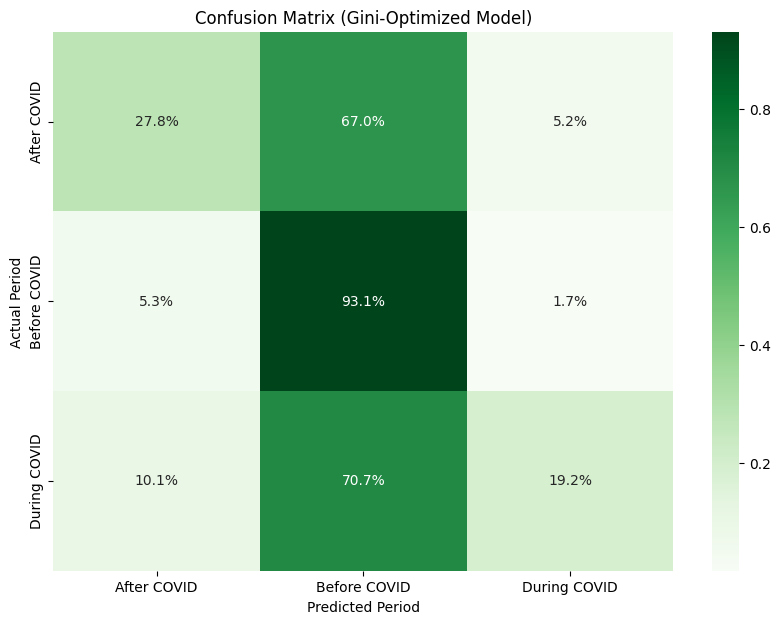

In [ ]:
# 1. Retraining the model using the BEST parameters found by the Gini study
best_xgb_gini = xgb.XGBClassifier(**study_xgb.best_params)
best_xgb_gini.fit(X_train_final, y_train_enc)

# 2. Getting the PREDICTIONS (Class Labels)
y_pred_gini = best_xgb_gini.predict(X_test_final)

# 3. Creating the Confusion Matrix
class_names = le.classes_
cm = confusion_matrix(y_test_enc, y_pred_gini, normalize='true')

# 4. Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt='.1%',
    xticklabels=class_names,
    yticklabels=class_names,
    cmap='Greens' # Changed color to Green to distinguish from the previous one
)
plt.ylabel('Actual Period')
plt.xlabel('Predicted Period')
plt.title('Confusion Matrix (Gini-Optimized Model)')
plt.show()

In [ ]:
#XGBoost for Accuracy
'''
def objective_xgb(trial):
    # 1. Define the Search Space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        # 'multi:softmax' is standard for multiclass
        'objective': 'multi:softmax',
        'num_class': 3,
        'n_jobs': -1, # Use all CPU cores
        'random_state': 42
    }

    # 2. Initialize and Train
    model = xgb.XGBClassifier(**param)

    # We use the evaluation set to stop training early if it stops improving
    # This saves a lot of time!
    model.fit(
        X_train_final, y_train_enc,
        eval_set=[(X_val_final, y_val_enc)],
        verbose=False
    )

    # 3. Predict and Evaluate
    preds = model.predict(X_val_final)
    accuracy = accuracy_score(y_val_enc, preds)

    return accuracy

# Create the study
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30) # XGBoost needs more trials

print("Best XGB Params:", study_xgb.best_params)
print("Best XGB Accuracy:", study_xgb.best_value)
'''